## Model The Future



In [ ]:
!pip install auto-sklearn

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_absolute_error as mae
from sklearn.inspection import permutation_importance
import autosklearn.regression
import sklearn
import matplotlib.pyplot as plt
from pprint import pprint
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

### Read the raw data

In [ ]:
fatal = pd.read_csv('https://raw.githubusercontent.com/darrentweng/ModelTheFuture23/main/SUDORS-Fatal-Overdose-Data.csv')
print(fatal.shape)
laws = pd.read_csv('https://raw.githubusercontent.com/darrentweng/ModelTheFuture23/main/controlled-substance-laws-by-state.csv')
print(laws.shape)
poverty = pd.read_csv('https://raw.githubusercontent.com/darrentweng/ModelTheFuture23/main/poverty-level-by-state.csv')
print(poverty.shape)

(66, 173)
(51, 14)
(51, 13)


In [ ]:
final = pd.merge(fatal, laws[['state','legalWeedStatus','medicinalWeedStatus','decriminalizedWeedStatus']], how='inner', left_on = 'Jurisdiction', right_on = 'state')
final = pd.merge(final, poverty[['state','PovertyRate']], how='inner', left_on = 'Jurisdiction', right_on = 'state')

In [ ]:
final.replace(9999,np.NaN,inplace=True) ## replace 9999 with Nan
final = final[final['Jurisdiction']!='Overall'] ## remove non-state rows

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
## Append Transform Columns with "T" appended to the names
def addTransformCols(df,cols):
  for t in cols:
    df[t+'T'] = le.fit_transform(df[t])

In [ ]:
## Run an automl "fit" on a "target" column
def RunML(df, features, target):
  print(f"Targeting ==== {target} =====")
  d = df[df[target].notna()] # skip the target Nan rows
  X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(d[features], d[[target]])
  
  automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=40, #120,
    per_run_time_limit=10 #30
  )
  automl.fit(X_train, y_train) # fit the model
  print(automl.leaderboard())
  # print(automl.show_models())
  print("MAE train:", mae(y_train, automl.predict(X_train)), "MAE test:", mae(y_test, automl.predict(X_test)))
  print(f"Train score {automl.score(X_train, y_train)}, Test score {automl.score(X_test, y_test)}")

  ## Compute permutation importance
  r = permutation_importance(automl, X_test, y_test, n_repeats=10, random_state=0)
  sort_idx = r.importances_mean.argsort()[::-1]
  plt.boxplot(r.importances[sort_idx].T, labels=[features[i] for i in sort_idx])
  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()
  #for i in sort_idx: # [::-1]:
  # print(f"{features[i]:10s}: {r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")
  
  ## Plot prediction vs actual
  predictions = automl.predict(X_test)
  prediction_train = automl.predict(X_train)
  plt.scatter(y_test, predictions, c='crimson')
  plt.scatter(y_train, prediction_train, c='orange')

  plt.xlabel(target+' actiual', fontsize=15)
  plt.ylabel(target+' predicted', fontsize=15)
  plt.axis('equal')
  plt.show()

### F1. State Level (Original)

In [ ]:
f1 = final.copy()[['Jurisdiction','alldrug_rate',"opioids_rate","imfs_rate","heroin_rate","rxopioids_rate","stimulant_percent",'naloxone_percent','homeless_percent','curr_paintrt_percent','returnopioids_percent','legalWeedStatus'
,'medicinalWeedStatus','decriminalizedWeedStatus','PovertyRate']]

In [ ]:
addTransformCols(f1,['legalWeedStatus','medicinalWeedStatus','decriminalizedWeedStatus'])

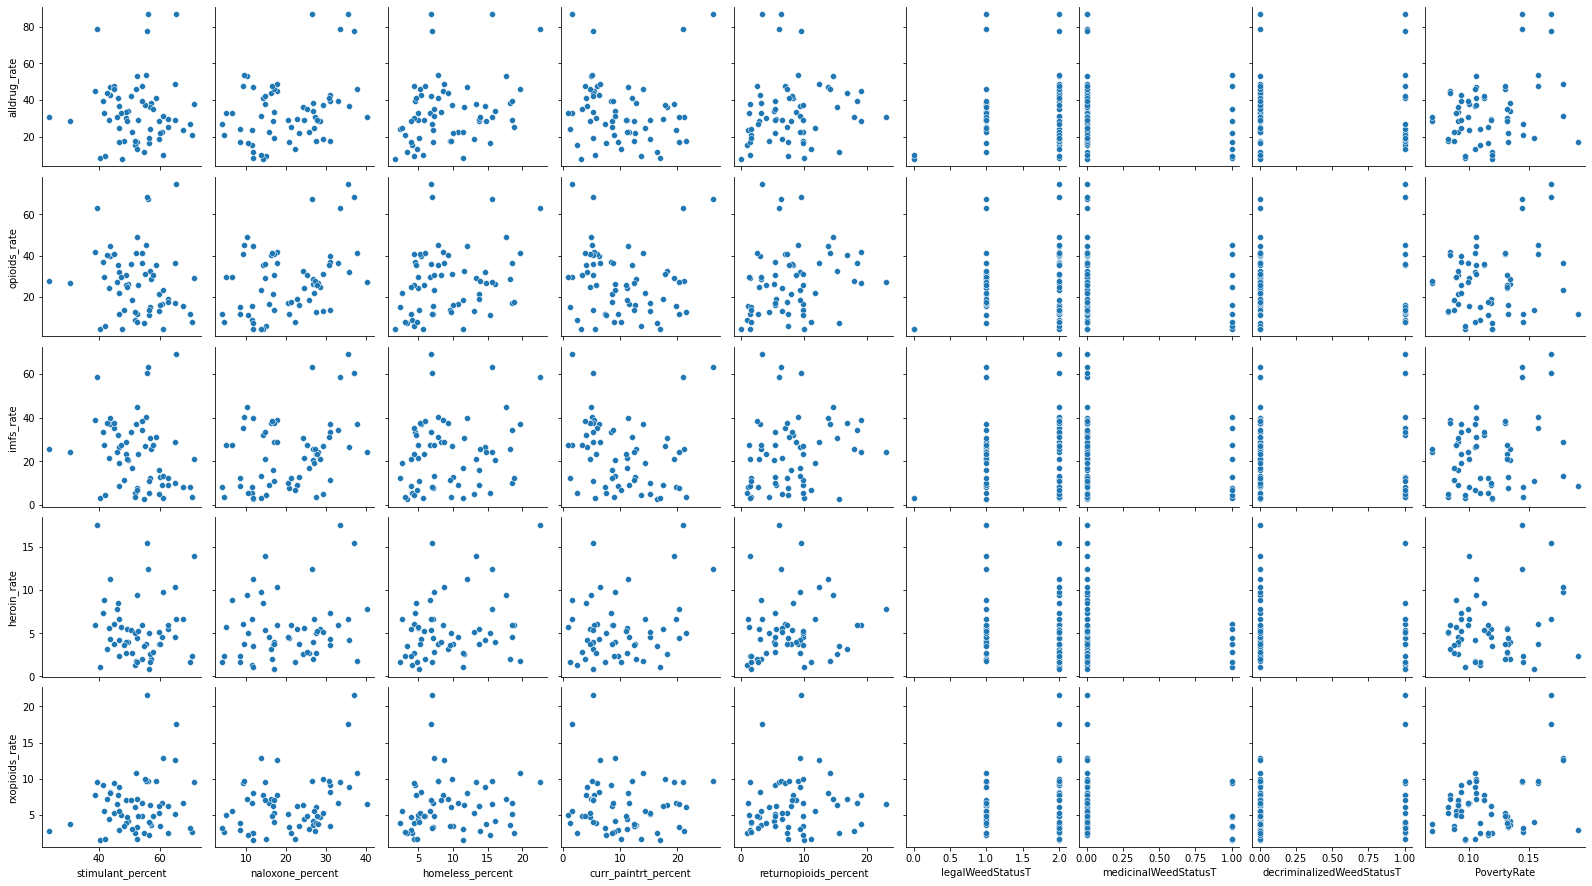

In [ ]:
features = ["stimulant_percent",'naloxone_percent','homeless_percent','curr_paintrt_percent','returnopioids_percent','legalWeedStatusT','medicinalWeedStatusT','decriminalizedWeedStatusT','PovertyRate']
targets = ['alldrug_rate',"opioids_rate","imfs_rate","heroin_rate","rxopioids_rate"] 
sns.pairplot(f1, x_vars=features, y_vars=targets)

Targeting ==== alldrug_rate =====
[WARNING] [2023-03-02 17:10:27,086:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
          rank  ensemble_weight              type      cost  duration
model_id                                                             
13           1              1.0  gaussian_process  0.559165  0.946137
MAE train: 3.086190481980642 MAE test: 8.451750636100769
Train score 0.8996249967248496, Test score 0.5350744742279459


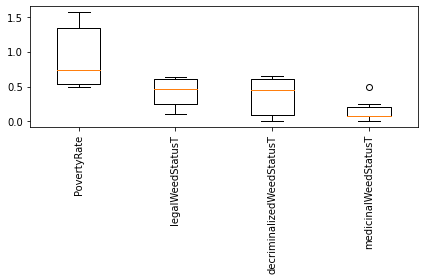

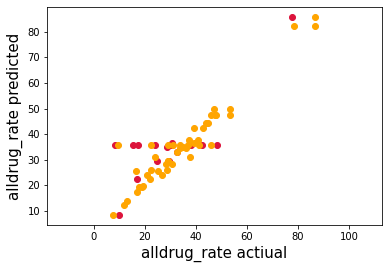

In [ ]:
# Sample run for debugging
features = ['legalWeedStatusT','medicinalWeedStatusT','decriminalizedWeedStatusT','PovertyRate']
RunML(f1,features,'alldrug_rate') #'alldrug_rate')

Targeting ==== alldrug_rate =====
[WARNING] [2023-03-02 15:16:28,542:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
          rank  ensemble_weight              type      cost  duration
model_id                                                             
19           1              0.5               sgd  0.673794  1.369118
12           2              0.5  gaussian_process  0.677802  0.927945
MAE train: 7.1399760961532595 MAE test: 11.146629214286804
Train score 0.6969289094992337, Test score 0.22764158910617127


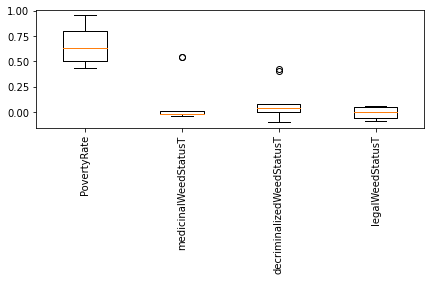

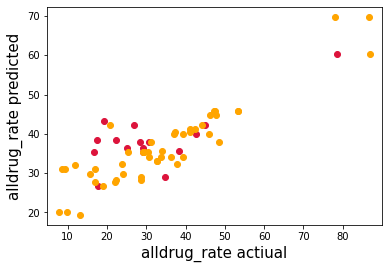

Targeting ==== opioids_rate =====
[WARNING] [2023-03-02 15:17:04,345:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
          rank  ensemble_weight              type      cost  duration
model_id                                                             
12           1             0.04  gaussian_process  0.943605  1.824384
4            2             0.70  gaussian_process  0.944145  0.903672
19           3             0.26  gaussian_process  0.995003  0.905339
MAE train: 4.171650347982844 MAE test: 10.442475996911526
Train score 0.7991406178791799, Test score 0.10749637100673937


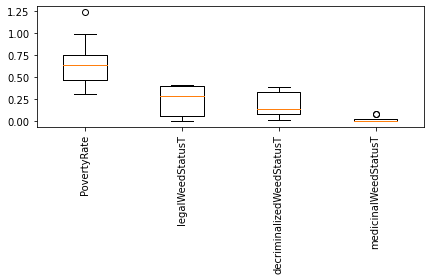

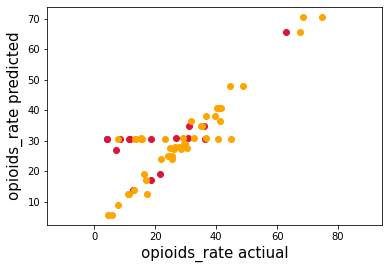

Targeting ==== imfs_rate =====
          rank  ensemble_weight              type      cost  duration
model_id                                                             
7            1             0.64  gaussian_process  0.820306  0.857572
2            2             0.36     random_forest  0.844271  2.199239
MAE train: 4.648422442091271 MAE test: 12.423224049806596
Train score 0.5703231490014579, Test score -0.014522989962018507


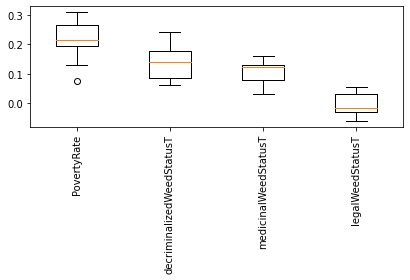

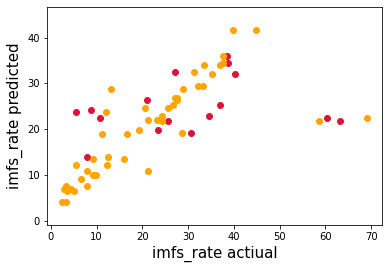

Targeting ==== heroin_rate =====
          rank  ensemble_weight         type      cost  duration
model_id                                                        
18           1              1.0  extra_trees  0.427231  1.554575
MAE train: 1.078969067051297 MAE test: 1.5260872173309323
Train score 0.7582264342573695, Test score 0.4286167119787867


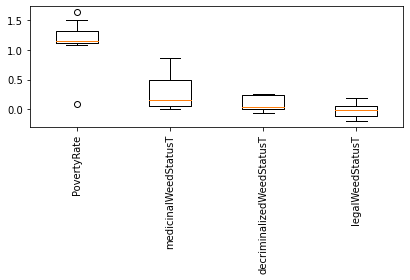

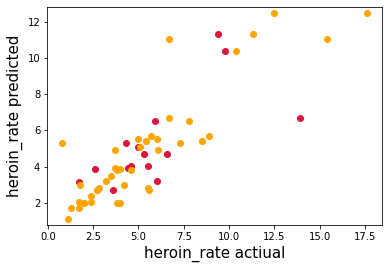

Targeting ==== rxopioids_rate =====
          rank  ensemble_weight              type      cost  duration
model_id                                                             
2            1             0.72     random_forest  0.316553  2.724667
19           2             0.12  gaussian_process  0.727303  1.136273
12           3             0.16  gaussian_process  0.746909  1.548880
MAE train: 0.858632957805758 MAE test: 2.647219344228506
Train score 0.8583657963520199, Test score 0.43360156288338514


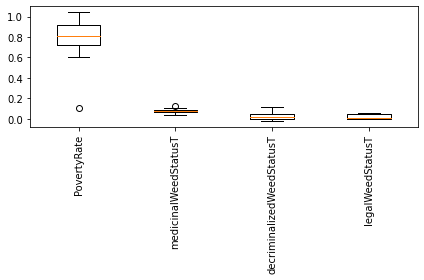

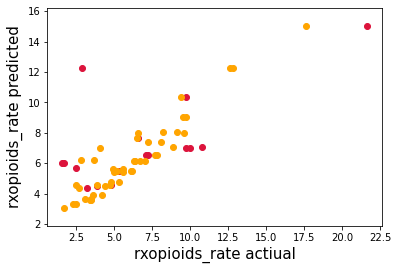

In [ ]:
features = ['legalWeedStatusT','medicinalWeedStatusT','decriminalizedWeedStatusT','PovertyRate']
for i in targets:
  RunML(f1,features,i)

Targeting ==== alldrug_rate =====
          rank  ensemble_weight               type      cost  duration
model_id                                                              
8            1             0.64   gaussian_process  0.754567  2.363826
10           2             0.36  gradient_boosting  0.800492  4.654668
MAE train: 5.314959013462066 MAE test: 12.763990223407745
Train score 0.5358271583082753, Test score -0.012207855483049812


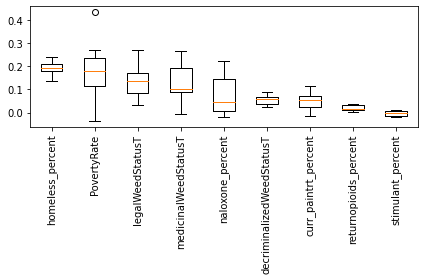

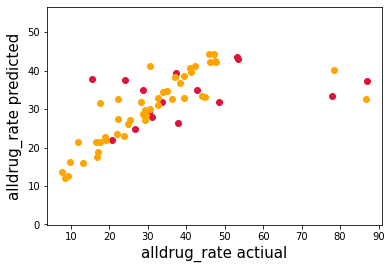

Targeting ==== opioids_rate =====
          rank  ensemble_weight               type      cost  duration
model_id                                                              
15           1             0.58      random_forest  0.797274  1.708634
10           2             0.08  gradient_boosting  0.827274  1.088380
11           3             0.34  gradient_boosting  0.863019  1.209343
MAE train: 5.589558777958156 MAE test: 15.498398179560901
Train score 0.5787199499193061, Test score -0.2708476336979395


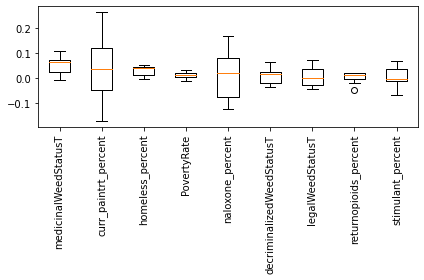

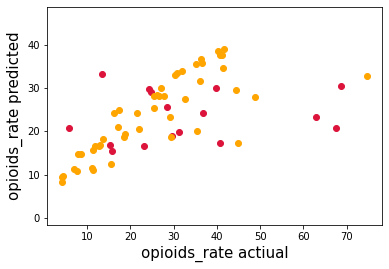

Targeting ==== imfs_rate =====
          rank  ensemble_weight               type      cost  duration
model_id                                                              
11           1             0.02  gradient_boosting  0.704916  1.188824
4            2             0.50     ard_regression  0.801740  0.905109
10           3             0.48  gradient_boosting  0.838798  1.236752
MAE train: 5.049021281809249 MAE test: 11.052710654214025
Train score 0.8033184012895209, Test score 0.01854097924232867


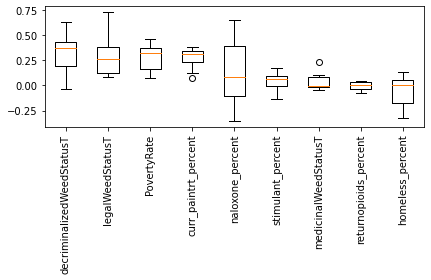

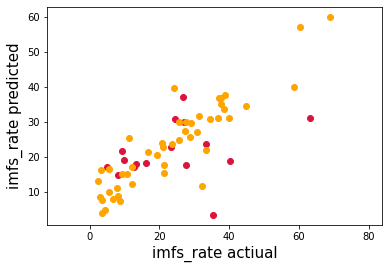

Targeting ==== heroin_rate =====
[WARNING] [2023-03-02 16:36:06,900:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
[WARNING] [2023-03-02 16:36:07,846:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
          rank  ensemble_weight              type      cost  duration
model_id                                                             
7            1             0.54  gaussian_process  0.860088  1.208555
18           2             0.46  gaussian_process  0.870056  0.921860
MAE train: 1.5033941972823368 MAE test: 2.4788423204421997
Train score 0.48126974604075057, Test score -0.4719450727158194


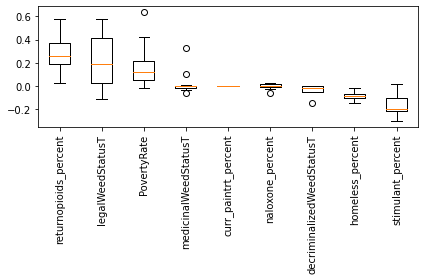

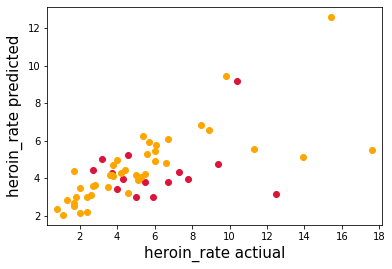

Targeting ==== rxopioids_rate =====
[WARNING] [2023-03-02 16:36:43,992:Client-EnsembleBuilder] No models better than random - using Dummy losses!
	Models besides current dummy model: 0
	Dummy models: 1
          rank  ensemble_weight              type      cost  duration
model_id                                                             
7            1              1.0  gaussian_process  0.755457  1.116486
MAE train: 1.5077827204828675 MAE test: 2.9889897465705872
Train score 0.7716811919175484, Test score -1.6504706529428979


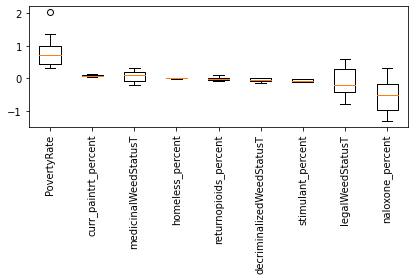

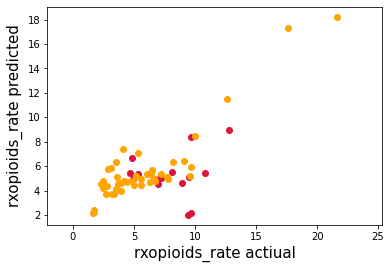

In [ ]:
features = ["stimulant_percent",'naloxone_percent','homeless_percent','curr_paintrt_percent','returnopioids_percent','legalWeedStatusT','medicinalWeedStatusT','decriminalizedWeedStatusT','PovertyRate']
for i in targets:
  RunML(f1,features,i)

### F2. State - Race

Need state population data by race to reconstruct death rate per racial group, which was not given by this dataset.

In [ ]:
pop = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_race/ethnicity')[0]
pop.rename(columns={'White alone (NH)':'White','Black or African American alone (NH)':'Black',
        'Native American or Alaska Native alone (NH)':'Native','Asian alone (NH)':'Asian',
        'Mixed Race/Multi-Racial (NH)':'Multi','Hispanic or Latino (any race)':'Hispanic'}, inplace=True
        )
pop = pop[['State','White','Black','Native','Asian','Multi','Hispanic']]

In [ ]:
f2 = pd.merge(final, pop, how='inner', left_on = 'Jurisdiction', right_on = 'State')

In [ ]:
f2['AsianRate'] = f2['asian_nh_deaths'] / f2['Asian'] * 100000
f2['NativeRate'] = f2['aian_nh_deaths'] / f2['Native'] * 100000
f2['BlackRate'] = f2['black_nh_deaths'] / f2['Black'] * 100000
f2['WhiteRate'] = f2['white_nh_deaths'] / f2['White'] * 100000
f2['MultiRate'] = f2['multi_nh_deaths'] / f2['Multi'] * 100000
f2['HispanicRate'] = f2['hisp_deaths'] / f2['Hispanic'] * 100000

<ipython-input-58-db6b804be296>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  f2['AsianRate'] = f2['asian_nh_deaths'] / f2['Asian'] * 100000
<ipython-input-58-db6b804be296>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  f2['NativeRate'] = f2['aian_nh_deaths'] / f2['Native'] * 100000
<ipython-input-58-db6b804be296>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) 

In [ ]:
cols = ['AsianRate','NativeRate','BlackRate','WhiteRate','MultiRate','HispanicRate']
f2['all_deaths'] = f2[cols].values.tolist()
f2['race'] = [['Asian','Native','Black','White','Multi','Hispanic'] for i in f2.index] # assign the list to all rows

In [ ]:
features = ["stimulant_percent",'naloxone_percent','homeless_percent','curr_paintrt_percent','returnopioids_percent','legalWeedStatus','medicinalWeedStatus','decriminalizedWeedStatus','PovertyRate']

In [ ]:
features.append('race')
targets = ['all_deaths'] 
all_col = ['Jurisdiction']
all_col.extend(targets)
all_col.extend(features)

In [ ]:
f2 = f2.explode(['all_deaths','race'])[all_col]
f2['all_deaths'] = f2['all_deaths'].astype(float)
addTransformCols(f2,['legalWeedStatus','medicinalWeedStatus','decriminalizedWeedStatus','race'])

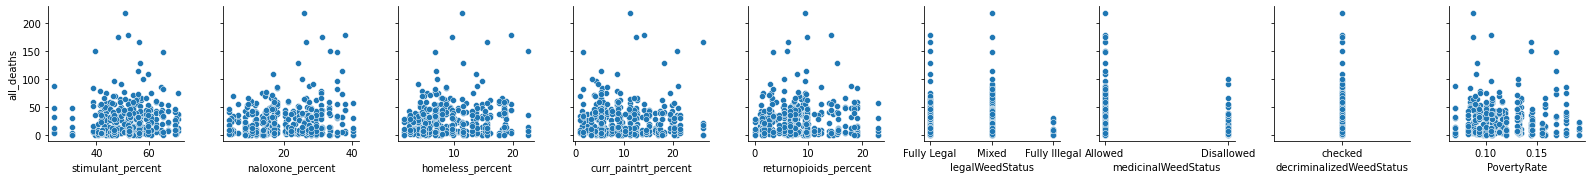

In [ ]:
sns.pairplot(f2, x_vars=features, y_vars=targets)

Targeting ==== all_deaths =====
          rank  ensemble_weight               type      cost  duration
model_id                                                              
7            1             0.44   gaussian_process  0.526821  3.368416
5            2             0.30  gradient_boosting  0.579806  1.464012
3            3             0.24      random_forest  0.581301  2.989480
4            4             0.02  gradient_boosting  0.612896  2.349613
MAE train: 8.461328021055598 MAE test: 12.63248417647558
Train score 0.7411127803294256, Test score 0.5644147923618444


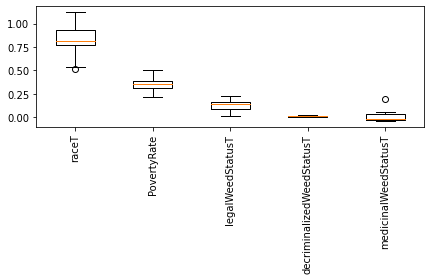

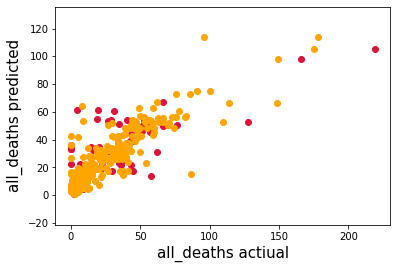

In [ ]:
features = ['legalWeedStatusT','medicinalWeedStatusT','decriminalizedWeedStatusT','PovertyRate','raceT']
for i in targets:
  RunML(f2,features,i)

Targeting ==== all_deaths =====
          rank  ensemble_weight               type      cost  duration
model_id                                                              
7            1             0.76  gradient_boosting  0.566453  1.464131
5            2             0.24   gaussian_process  0.698574  7.231984
MAE train: 9.399071694316465 MAE test: 9.751184096191055
Train score 0.6860799139133136, Test score 0.47793839983819375


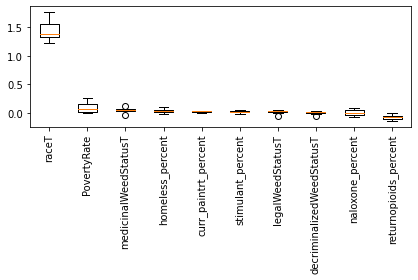

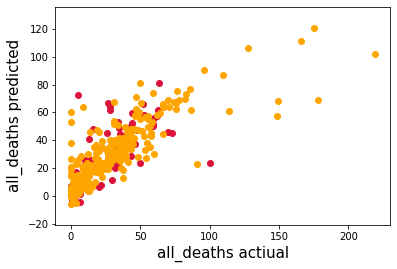

In [ ]:
features = ["stimulant_percent",'naloxone_percent','homeless_percent','curr_paintrt_percent','returnopioids_percent','legalWeedStatusT','medicinalWeedStatusT','decriminalizedWeedStatusT','PovertyRate','raceT']
for i in targets:
  RunML(f2,features,i)

### Step-by-step

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(f1[features], f1['alldrug_rate']) # split the data into 75% train and 25% test

In [ ]:
import autosklearn.regression
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=40,
    per_run_time_limit=10
)
automl.fit(X_train, y_train) # fit the classifier

AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     per_run_time_limit=10, time_left_for_this_task=40)

In [ ]:
print(automl.leaderboard())

          rank  ensemble_weight              type      cost  duration
model_id                                                             
7            1             0.48  gaussian_process  0.467569  0.814951
8            2             0.26    ard_regression  0.797889  1.003870
13           3             0.22  gaussian_process  0.842417  1.562006
14           4             0.04     random_forest  0.929868  2.062239


In [ ]:
predictions = automl.predict(X_test) # predict on the normalized test set
accuracy = automl.score(X_test,y_test) # compute accuracy score

print("Accuracy:", accuracy)

Accuracy: 0.552396114623887


In [ ]:
prediction_train = automl.predict(X_train)

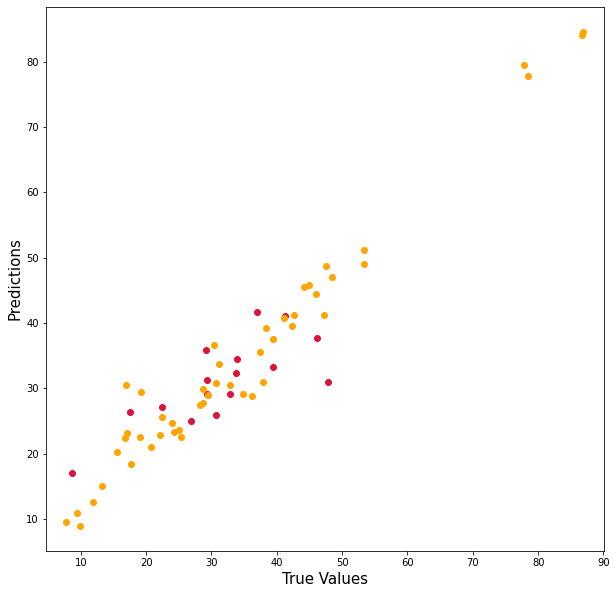

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions, c='crimson')
plt.scatter(y_train, prediction_train, c='orange')

plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

mae(y_train, automl.predict(X_train)), mae(y_test, automl.predict(X_test))

(5.34491197814544, 12.932615229487421)

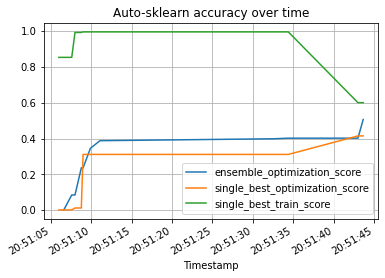

In [ ]:
poT = automl.performance_over_time_
poT.plot(
    x="Timestamp",
    kind="line",
    legend=True,
    title="Auto-sklearn accuracy over time",
    grid=True,
)
plt.show()

In [ ]:
from sklearn.inspection import plot_partial_dependence, permutation_importance
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [20, 8]
start = time.time()
r = permutation_importance(automl, X_test, y_test, n_repeats=10, random_state=0)
sort_idx = r.importances_mean.argsort()[::-1]
print(int(time.time()) - start, ' sec passed')

1.8525254726409912  sec passed


In [ ]:
s = automl.score(X_train, y_train)
print(f"Train score {s}")
s = automl.score(X_test, y_test)
print(f"Test score {s}")

Train score 0.7717140395317481
Test score 0.21469106016726336


In [ ]:
for i in sort_idx: # [::-1]:
    print(f"{features[i]:10s}: {r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")

PovertyRate: 0.132 +/- 0.030
legalWeedStatus: 0.118 +/- 0.025
curr_paintrt_percent: 0.083 +/- 0.016
medicinalWeedStatus: 0.040 +/- 0.017
naloxone_percent: 0.029 +/- 0.020
homeless_percent: 0.019 +/- 0.027
returnopioids_percent: 0.001 +/- 0.044
decriminalizedWeedStatus: -0.083 +/- 0.052
